# Double and Pseudo Double source plane cosmology forecast

In [40]:
# import standard python modules
import numpy as np
import corner
import copy
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from astropy.table import Table
from multiprocessing import Pool, cpu_count

%matplotlib inline

# import lenstronomy and hierArc modules
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from hierarc.Sampling.ParamManager.cosmo_param import CosmoParam
from hierarc.Sampling.mcmc_sampling import MCMCSampler

import emcee
from chainconsumer import Chain
from chainconsumer import ChainConsumer
from chainconsumer import PlotConfig
from chainconsumer import ChainConfig
from chainconsumer.plotting import plot_contour

from hierarc.Likelihood.LensLikelihood.double_source_plane import (
    beta_double_source_plane, beta2theta_e_ratio
)

from utils import normalize_data, get_pairs_table_PDSPL, kdtree_matching_n_dim

# imports directly from the project repository
# from plot_util import *

# matplotlib configs
from pylab import rc

# rc("axes", linewidth=2)
# rc("xtick", labelsize=15)
# rc("ytick", labelsize=15)

## Forecast settings

Here we describe the redshift distribution, precision on Einstein radii ratios of an anticipated sample


In [41]:
# define a cosmology
cosmology = "w0waCDM"  # Flat wCDM cosmology
# other options are: "FLCDM FwCDM", "w0waCDM", "oLCDM"
om_true = 0.3
w0_true = -1
wa_true = 0
h0_true = 70
kwargs_cosmo_true = {"h0": h0_true, "om": om_true, "w0": w0_true, "wa": wa_true}  # cosmological model of the forecast

# create astropy.cosmology instance of input cosmology
cosmo_param = CosmoParam(cosmology=cosmology)
cosmo_true = cosmo_param.cosmo(kwargs_cosmo_true)

# define hierarchical model

kwargs_model = {
    "lambda_mst_sampling": True,
    "lambda_mst_distribution": "NONE",  # TODO: switch to GAUSSIAN
    "gamma_pl_global_sampling": True,
    "gamma_pl_global_dist": "NONE",  # TODO: switch to GAUSSIAN
    "log_scatter": False,
}

gamma_pl_mean = 2.078
gamma_pl_sigma = 0.16

lambda_mst_mean = 1.0
lambda_mst_sigma = 0.05


def draw_lens_from_given_zs(z_lens, z1, z2, 
                            lambda_mst_mean, lambda_mst_sigma, gamma_pl_mean, gamma_pl_sigma, 
                            sigma_beta,
                            down_sampling=1, with_noise=False):
    """
    draw the likelihood object of a double source plane lens

    :param z_lens: redshift of the lens
    :param z1: redshift of the first source plane
    :param z2: redshift of the second source plane
    :param lambda_mst_mean: mean value of the mass-sheet transformation parameter
    :param lambda_mst_sigma: standard deviation of the mass-sheet transformation parameter
    :param gamma_pl_mean: mean value of the power-law slope of the lensing potential
    :param gamma_pl_sigma: standard deviation of the power-law slope of the lensing potential
    :param sigma_beta: relative precision on Einstein radius, used to compute the noise on the measured beta
    :param down_sampling: downsampling factor, noise will be reduced by sqrt(down_sampling)
    :param with_noise: if True, add noise to the measured beta 
    """
    beta = beta_double_source_plane(z_lens, z1, z2, cosmo_true)
    
    beta_e_list = []
    beta_e_mean = beta2theta_e_ratio(beta_dsp=beta, gamma_pl=gamma_pl_mean, lambda_mst=lambda_mst_mean)
    for i in range(100):
        lambda_mst = np.random.normal(lambda_mst_mean, lambda_mst_sigma)
        gamma_pl = np.random.normal(gamma_pl_mean, gamma_pl_sigma)
        beta_e_ = beta2theta_e_ratio(beta_dsp=beta, gamma_pl=gamma_pl, lambda_mst=lambda_mst)
        beta_e_list.append(beta_e_)
    beta_e_list = np.array(beta_e_list)
    beta_e_mean_ = np.mean(beta_e_list)
    beta_e_sigma = np.sqrt(np.std(beta_e_list)**2 + (sigma_beta * beta_e_mean)**2) / np.sqrt(down_sampling)

    if with_noise:
        beta_measured = beta_e_mean + np.random.normal(loc=0, scale=beta_e_sigma)
    else:
        beta_measured = beta_e_mean

    kwargs_likelihood = {
        "z_lens": z_lens,
        "z_source": z1,
        "z_source2": z2,
        "beta_dspl": beta_measured,
        "sigma_beta_dspl": beta_e_sigma,
        "likelihood_type": "DSPL",
    }
    return kwargs_likelihood


## Settings for population of DSPL

In [42]:
# =====================================
# Settings for population of DSPL
# =====================================

# number of double source plane lenses
num_dspl = 87

sigma_beta_dspl = 0.01  # relative precision on Einstein radius ratio

kwargs_dspl_list = []

for i in range(num_dspl):
    z_lens = np.random.uniform(low=0.01, high=2.5)
    z1 = 0
    while z1 < z_lens:
        z1 = np.random.uniform(low=0.1, high=5)
    z2 = 0
    while z2 < z_lens:
        z2 = np.random.uniform(low=0.1, high=5)
    if z1 > z2:
        z1, z2 = z2, z1
    kwargs_dspl_list.append(draw_lens_from_given_zs(z_lens, z1, z2,
                                                     lambda_mst_mean, lambda_mst_sigma, gamma_pl_mean, gamma_pl_sigma,
                                                     sigma_beta=sigma_beta_dspl,
                                                     with_noise=True,))

/var/folders/4r/jq9w4fy92y9_bqzvdfk2d5h40000gn/T/ipykernel_19382/578038189.py:49: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(z_lens, z1, z2, cosmo_true)
/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likelihood/LensLikelihood/double_source_plane.py:80: RuntimeWarning: invalid value encountered in scalar power
  return (beta_dsp - (1 - lambda_mst) * (1 - beta_dsp)) ** (1 / (gamma_pl - 1))


## Settings for population of PDSPLs

In [43]:
# load the GGL data tables with different sky areas of lenses but galaxy population is on 100 deg^2
sky_area = "1000.0"
GGL_data_table = Table.read(f"../data/GGL_{sky_area}_SQDEG_NON_SIS.fits", format='fits')

contrast_mask = np.zeros(len(GGL_data_table), dtype=bool)
# ps_magnification_mask = np.zeros(len(GGL_data_table), dtype=bool)
for i in range(len(GGL_data_table)):
    
    # contrast mask
    all_vals = GGL_data_table['contrast_ratio_i'][i]
    all_vals = all_vals[~np.isnan(all_vals)]
    # get linear scale values
    all_vals = 10**(-0.4 * all_vals)
    contrast_mask[i] = np.all(all_vals > 2) # all images should have contrast ratio > 2

    # point source magnification mask
    # ps_magnifications = GGL_data_table['ps_magnification'][i]
    # ps_magnifications = ps_magnifications[~np.isnan(ps_magnifications)]
    # high_mag = np.any(np.abs(ps_magnifications) > 3)
    # ps_magnification_mask[i] = high_mag

# add a column for r_band lensed source magnitude
GGL_data_table['mag_S_r_lensed'] = GGL_data_table['mag_S_r'] - 2.5 * np.log10(np.abs(GGL_data_table['es_magnification']))
GGL_data_table['mag_S_i_lensed'] = GGL_data_table['mag_S_i'] - 2.5 * np.log10(np.abs(GGL_data_table['es_magnification']))

GGL_data_table = GGL_data_table[ 
                                #  (GGL_data_table['mag_D_i'] >= 19) 
                                (GGL_data_table['mag_S_i_lensed'] < 28)
                                & (GGL_data_table['mag_D_i'] < 28)
                                & (contrast_mask)
                                & (np.abs(GGL_data_table['es_magnification']) > 3)
                                # & (ps_magnification_mask)
                                ]

# add g-r and r-i colors for deflector
GGL_data_table['color_D_gr'] = GGL_data_table['mag_D_g'] - GGL_data_table['mag_D_r']
GGL_data_table['color_D_ri'] = GGL_data_table['mag_D_r'] - GGL_data_table['mag_D_i']

GGL_data_table

lens_id,z_D,z_S,theta_E,sigma_v_D,stellar_mass_D,mag_S_i,mag_S_r,mag_S_g,mag_S_z,mag_S_y,mag_D_i,mag_D_r,mag_D_g,mag_D_z,mag_D_y,size_D,e1_mass_D,e2_mass_D,e_mass_D,gamma_pl,R_e_kpc,Sigma_half_Msun/pc2,surf_bri_mag/arcsec2,num_images,contrast_ratio_i,contrast_ratio_r,contrast_ratio_g,contrast_ratio_z,contrast_ratio_y,ps_magnification,es_magnification,mag_S_r_lensed,mag_S_i_lensed,color_D_gr,color_D_ri
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,object,object,object,object,object,object,float64,float64,float64,float64,float64
0,1.4100545160514653,3.0727081900409807,1.0394223736804657,322.18352132091013,898021822321.8273,26.997924646512757,27.235776692795547,27.38455835470937,26.8441045176299,26.87436346092892,23.00001022044323,24.090258809208024,24.335544556948285,22.401497397135664,21.715771776469936,0.8180382665448649,-0.011795912351042848,-0.02745052105530734,0.029877661461388788,2.110359002054998,6.901449886929194,7714.078641013165,26.387516181269344,2,[-6.07849222 -5.43311691 nan nan],[-6.93088876 -6.28551345 nan nan],[-7.02739285 -6.38201754 nan nan],[-5.63379953 -4.98842422 nan nan],[-4.91781496 -4.27243965 nan nan],[ 8.86165444 -6.93169241 nan nan],17.14621846496409,24.15035581054937,23.91250376426658,0.24528574774026168,1.0902485887647941
1,1.512036472199786,3.5686637659831355,0.7950335305780947,276.79601364882336,631639102345.0789,26.363416296607447,26.480551905421976,27.000225234246358,26.146211923032425,25.995132897294532,23.80501970261783,24.54906123722738,24.718629067848607,23.148795441228184,22.621902775892362,0.7762963822931552,0.1791854226095538,-0.1221861538512963,0.2168798558389807,2.040017714484443,6.571199267618647,5494.7674578724545,26.641689768438013,2,[-6.96403094 -5.41819479 nan nan],[-7.59093687 -6.04510072 nan nan],[-7.24083137 -5.69499522 nan nan],[-6.52501106 -4.97917491 nan nan],[-6.14919742 -4.60336127 nan nan],[ 2.29118084 -3.44058908 nan nan],6.005830021992177,24.534119314017765,24.416983705203236,0.16956783062122582,0.7440415346095506
3,1.3797860102766537,3.8402271470589353,1.341475497633054,335.1624264109542,954584834029.128,25.664120663507507,25.677461122483667,26.26926075078438,25.55752905540469,25.51873778929458,22.933048599515747,24.163456001973525,24.507718175728524,22.33877280321924,21.586934416855815,0.984563119691017,-0.06604917153088401,0.04992697499244765,0.08279611036644555,2.132413604569742,8.29357660719643,7141.681740523826,26.946671097246604,2,[-6.72985648 -4.61232356 nan nan],[-7.94692342 -5.8293905 nan nan],[-7.69938597 -5.58185305 nan nan],[-6.24217229 -4.12463937 nan nan],[-5.52912517 -3.41159225 nan nan],[ 2.78547602 -0.79233817 nan nan],3.619476583088337,24.280846694432505,24.267506235456345,0.34426217375499846,1.2304074024577787
4,0.9793203674576667,1.8996210953724448,1.002378361387467,313.59344994270543,835924484040.4642,27.113930820497156,27.320815962859538,27.619005125802094,26.795546028971767,26.67342645821922,21.48287379065373,22.541816482317476,24.265037911804146,20.55068419365625,20.116117277377466,1.1698315880559762,0.11061615711224486,0.3059620082770893,0.32534394834272007,2.079331679100114,9.321718744540453,4962.05227285814,27.118639008488355,4,[-5.46995568 -5.13419538 -4.84649732 -3.80749367],[-6.32201323 -5.98625293 -5.69855487 -4.65955122],[-7.74704549 -7.41128519 -7.12358713 -6.08458348],[-4.85615087 -4.52039057 -4.23269251 -3.19368886],[-4.54370353 -4.20794323 -3.92024516 -2.88124152],[ 2.55335595 8.5593204 -7.43982188 -0.94551283],21.064607519700395,24.011932533684487,23.805047391322105,1.7232214294866708,1.058942691663745
5,0.6815442845076662,4.65917930605592,1.2198873745612413,249.98784320171163,483185142916.29535,25.95567255233216,26.235499322457024,27.941918325034415,26.068242364989068,25.93375548892945,20.241610548168815,21.36426974233222,22.54110727474564,19.798951149564715,19.49854978962359,1.21547752

In [45]:
################################################################################
### make all the samples
################################################################################

# 1 year coadd
# point source depths: g < 26.0, r < 25.7, i < 25.0, z < 24.3, y < 23.1
# extended source depths are 1 mag shallower: g < 25.0, r < 24.7, i < 24.0, z < 23.3, y < 22.1
lsst_1_yr_coadd_mag_depth_mask = (
                        (GGL_data_table['mag_D_i'] < 24.0)
                        & (GGL_data_table['mag_S_i_lensed'] < 24.0)
)

# 10 year coadd
# point source depths: g < 27.4, r < 27.5, i < 26.8, z < 26.1, y < 24.9
# extended source depths are 1 mag shallower: g < 26.4, r < 26.5, i < 25.8, z < 25.1, y < 23.9
lsst_10_yr_coadd_mag_depth_mask = (
                        (GGL_data_table['mag_D_i'] < 25.8)
                        & (GGL_data_table['mag_S_i_lensed'] < 25.8)
)

# 4MOST spec-z for sources: r < 23.5 and z < 1.5

lsst_4MOST_mag_depth_mask = (
                        # (GGL_data_table['mag_D_r'] < 24.5)
                        (GGL_data_table['mag_S_r_lensed'] < 24)
                        & (GGL_data_table['z_S'] < 1.5) # 4MOST limit
)


lsst_1_yr_GGL_table = GGL_data_table[lsst_1_yr_coadd_mag_depth_mask]
lsst_10_yr_GGL_table = GGL_data_table[lsst_10_yr_coadd_mag_depth_mask]
lsst_4MOST_GGL_table = GGL_data_table[lsst_4MOST_mag_depth_mask]

GGL_tables = {
    "SLSim 1000 deg^2": GGL_data_table,
    "LSST 1-yr": lsst_1_yr_GGL_table,
    "LSST 10-yr": lsst_10_yr_GGL_table,
    "LSST + 4MOST spec-z": lsst_4MOST_GGL_table,
    "LSST + 4MOST spec-z + sigma_v": lsst_4MOST_GGL_table[np.random.choice(len(lsst_4MOST_GGL_table), size=len(lsst_4MOST_GGL_table)//2, replace=False)],  # same table as above, but with half the number of lenses
}

################################################################################
### find_pairing_tables
################################################################################


GGL_pairing_specs = {}

for key in GGL_tables.keys():
    data_table = GGL_tables[key]
    num_lenses = len(data_table)
    print(f"{key}: {num_lenses} lenses")

    if key.startswith("LSST + 4MOST"):
        z_error = 1e-4 # spectroscopic redshift error
        new_z_D = data_table['z_D'] + np.random.normal(loc=0, scale=z_error)
    else:
        z_error = 0.03 * (1 + data_table['z_D'])  # photometric redshift error
        new_z_D = data_table['z_D'] + np.random.normal(loc=0, scale=z_error)


    if key == "LSST + 4MOST spec-z + sigma_v":
        # use sigma_v as an additional dimension for kD-tree matching

        # introduce measurement error on sigma_v
        error_sigma_v = 0.1 * data_table['sigma_v_D']  # 10% error on sigma_v
        new_sigma_v = data_table['sigma_v_D'] + np.random.normal(loc=0, scale=error_sigma_v)

        points = np.stack([
            normalize_data(data_table['R_e_kpc'], type='zscore'),
            normalize_data(data_table['mag_D_i'], type='zscore'),
            normalize_data(data_table['color_D_gr'], type='zscore'),
            normalize_data(data_table['color_D_ri'], type='zscore'),
            normalize_data(new_z_D, type='zscore'),
            normalize_data(new_sigma_v, type='zscore')],
            axis=1)
    else:

        points = np.stack([
            normalize_data(data_table['R_e_kpc'], type='zscore'),
            normalize_data(data_table['mag_D_i'], type='zscore'),
            normalize_data(data_table['color_D_gr'], type='zscore'),
            normalize_data(data_table['color_D_ri'], type='zscore'),
            normalize_data(new_z_D, type='zscore')],
            axis=1)
    
    indices, _ = kdtree_matching_n_dim(points=points, n_neighbors=2, unique_pairs=True)
    pairs_table = get_pairs_table_PDSPL(data_table, pair_indices=indices, cosmo=cosmo_true, progress_bar=False)

    num_pairs = len(pairs_table)
    scatter_in_beta_E = np.std(1 - pairs_table["beta_E_pseudo"]/pairs_table["beta_E_DSPL"])

    print(f"  -> {num_pairs} pairs found with scatter in beta_E of {scatter_in_beta_E:.4f}")

    GGL_pairing_specs[key] = {
        "num_lenses": num_lenses,
        "num_pairs": num_pairs,
        "rel_scatter_in_beta_E": scatter_in_beta_E,
        "pairs_table": pairs_table,
    }

SLSim 1000 deg^2: 15987 lenses
  -> 11767 pairs found with scatter in beta_E of 0.1886
LSST 1-yr: 9398 lenses
  -> 6943 pairs found with scatter in beta_E of 0.1816
LSST 10-yr: 15859 lenses
  -> 11654 pairs found with scatter in beta_E of 0.1885
LSST + 4MOST spec-z: 423 lenses
  -> 310 pairs found with scatter in beta_E of 0.2006
LSST + 4MOST spec-z + sigma_v: 211 lenses
  -> 152 pairs found with scatter in beta_E of 0.2343


In [46]:
################################################################################
### compute the scatter in beta_E for a smaller sized sample to speed up the forecast sampling
################################################################################

num_PDSPL_samples = 200  # number of PDSPLs to use for forecast sampling

curr_sky_area = 1000.0  # deg^2
desired_sky_area = 20000.0  # deg^2
down_sampling_factor = desired_sky_area / curr_sky_area


sigma_beta_meas = 0.01  # relative uncertainty on the measured Einstein radius due to measurement errors
sigma_beta_los = 0.01  # relative uncertainty on the measured Einstein radius due to line-of-sight structures


for key in GGL_pairing_specs.keys():
    num_lenses = GGL_pairing_specs[key]["num_lenses"]
    num_pairs = GGL_pairing_specs[key]["num_pairs"]
    scatter_in_beta_E = GGL_pairing_specs[key]["rel_scatter_in_beta_E"]

    expected_scatter_in_beta_E = scatter_in_beta_E * (down_sampling_factor)**(-0.11)  # empirical scaling relation from `num_pairs_scaling.ipynb` notebook
    expected_scatter_in_beta_E = np.sqrt(expected_scatter_in_beta_E**2 + sigma_beta_meas**2 + sigma_beta_los**2)
    down_sampling_factor_effective = num_pairs * down_sampling_factor / num_PDSPL_samples

    GGL_pairing_specs[key]["expected_scatter_in_beta_E"] = expected_scatter_in_beta_E
    GGL_pairing_specs[key]["down_sampling_factor_effective"] = down_sampling_factor_effective
    GGL_pairing_specs[key]["num_PDSPL_samples_for_down_sampling"] = num_PDSPL_samples

    print(f"{key.ljust(20)}: {num_lenses:5d} lenses, {num_pairs:5d} pairs, beta_E scatter: {scatter_in_beta_E*100:.2f}% (1K deg^2) -> {expected_scatter_in_beta_E*100:.2f}% (20K deg^2; meas. + LOS included) || {down_sampling_factor_effective:.4f} down-sampling factor for {num_PDSPL_samples} samples")

SLSim 1000 deg^2    : 15987 lenses, 11767 pairs, beta_E scatter: 18.86% (1K deg^2) -> 13.64% (20K deg^2; meas. + LOS included) || 1176.7000 down-sampling factor for 200 samples
LSST 1-yr           :  9398 lenses,  6943 pairs, beta_E scatter: 18.16% (1K deg^2) -> 13.14% (20K deg^2; meas. + LOS included) || 694.3000 down-sampling factor for 200 samples
LSST 10-yr          : 15859 lenses, 11654 pairs, beta_E scatter: 18.85% (1K deg^2) -> 13.63% (20K deg^2; meas. + LOS included) || 1165.4000 down-sampling factor for 200 samples
LSST + 4MOST spec-z :   423 lenses,   310 pairs, beta_E scatter: 20.06% (1K deg^2) -> 14.49% (20K deg^2; meas. + LOS included) || 31.0000 down-sampling factor for 200 samples
LSST + 4MOST spec-z + sigma_v:   211 lenses,   152 pairs, beta_E scatter: 23.43% (1K deg^2) -> 16.91% (20K deg^2; meas. + LOS included) || 15.2000 down-sampling factor for 200 samples


In [47]:
################################################################################
### prepare samples for forecasting
################################################################################

dict_kwargs_pseudo_dspl_lists = {}

for key in GGL_pairing_specs.keys():
    num_PDSPL_samples = GGL_pairing_specs[key]["num_PDSPL_samples_for_down_sampling"]
    expected_scatter_in_beta_E = GGL_pairing_specs[key]["expected_scatter_in_beta_E"]
    down_sampling_factor_effective = GGL_pairing_specs[key]["down_sampling_factor_effective"]
    pairs_table = GGL_pairing_specs[key]["pairs_table"]

    kwargs_pseudo_dspl_list = []
    for i in range(num_PDSPL_samples):
        # pick random pair
        rand_index = np.random.choice(len(pairs_table))
        z_lens = pairs_table["z_D"][rand_index]
        z1 = pairs_table["z_S1"][rand_index]
        z2 = pairs_table["z_S2"][rand_index]
           
        kwargs_pseudo_dspl_list.append(draw_lens_from_given_zs(
            z_lens=z_lens, z1=z1, z2=z2,
            lambda_mst_mean=lambda_mst_mean, lambda_mst_sigma=lambda_mst_sigma,
            gamma_pl_mean=gamma_pl_mean, gamma_pl_sigma=gamma_pl_sigma,
            sigma_beta=expected_scatter_in_beta_E, down_sampling=down_sampling_factor_effective,
            with_noise=True))

    dict_kwargs_pseudo_dspl_lists[key] = kwargs_pseudo_dspl_list

/var/folders/4r/jq9w4fy92y9_bqzvdfk2d5h40000gn/T/ipykernel_19382/578038189.py:49: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(z_lens, z1, z2, cosmo_true)


## hierArc sampling settings

In [48]:
################################################################################
### specify forecast samples to run
################################################################################

keys_to_run_forecast = [
    # "LSST 1-yr",
    "LSST 10-yr",
    "LSST + 4MOST spec-z",
]

display_names_for_plots = {
    "LSST 1-yr": "LSST Single Visit Depth",
    "LSST 10-yr": "LSST Y10-like Depth",
    "LSST + 4MOST spec-z": "LSST Y10 + 4MOST spec-z",
}

for key in keys_to_run_forecast:
    # append uncertainty on beta_E over 20,000 deg^2 sky area, including measurement error and LOS contribution
    expected_scatter_in_beta_E = GGL_pairing_specs[key]["expected_scatter_in_beta_E"]
    display_names_for_plots[key] += f" ({expected_scatter_in_beta_E*100:.2f}% in beta_E)"

################################################################################

display_names_for_plots

{'LSST 1-yr': 'LSST Single Visit Depth',
 'LSST 10-yr': 'LSST Y10-like Depth (13.63% in beta_E)',
 'LSST + 4MOST spec-z': 'LSST Y10 + 4MOST spec-z (14.49% in beta_E)'}

In [49]:
kwargs_mean_start = {"kwargs_cosmo": {"h0": 70, "om": 0.3, "w0": -1, "wa": 0},
                    "kwargs_lens": {"lambda_mst": lambda_mst_mean, "lambda_mst_sigma": lambda_mst_sigma,
                                    "gamma_pl_mean": gamma_pl_mean, "gamma_pl_sigma": gamma_pl_sigma}}

kwargs_sigma_start = {"kwargs_cosmo": {"h0": 10, "om": 0.05, "w0": 0.2, "wa": 0.1},
                     "kwargs_lens": {"lambda_mst": 0.1, "lambda_mst_sigma": 0.01,
                                     "gamma_pl_mean": 0.1, "gamma_pl_sigma": 0.01}}


kwargs_bounds = {
    "kwargs_lower_cosmo": {"h0": 0, "om": 0, "w0": -2, "wa": -3},
    "kwargs_upper_cosmo": {"h0": 200, "om": 1, "w0": 0, "wa": 3},
    "kwargs_fixed_cosmo": {"h0": kwargs_cosmo_true["h0"]},
    
    "kwargs_lower_lens": {"lambda_mst": 0.8, "gamma_pl_mean": 1.5},
    "kwargs_upper_lens": {"lambda_mst": 1.2, "gamma_pl_mean": 2.5},
    "kwargs_fixed_lens": {"gamma_pl_sigma": gamma_pl_sigma, "lambda_mst_sigma": lambda_mst_sigma}
}


kwargs_sampler = {"custom_prior": None,
                  "interpolate_cosmo": False,
                  "num_redshift_interp": 100,
                  "cosmo_fixed": None,
                 }



In [50]:

# backend_dspl = emcee.backends.HDFBackend(
#     os.path.join(posterior_directory, "dspl_wCDM.h5")
# )

# backend_pseudo = emcee.backends.HDFBackend(
#     os.path.join(posterior_directory, "pseudo_wCDM.h5")
# )

# backend_joint = emcee.backends.HDFBackend(
#     os.path.join(posterior_directory, "joint_wCDM.h5")
# )




mcmc_sampler_dspl = MCMCSampler(kwargs_dspl_list, cosmology=cosmology,
                           kwargs_model=kwargs_model, kwargs_bounds=kwargs_bounds,
                          **kwargs_sampler)

mcmc_samplers_pseudo = {}
for key in keys_to_run_forecast:
    kwargs_pseudo_dspl_list = dict_kwargs_pseudo_dspl_lists[key]
    mcmc_samplers_pseudo[key] = MCMCSampler(kwargs_pseudo_dspl_list, cosmology=cosmology, 
                               kwargs_model=kwargs_model, kwargs_bounds=kwargs_bounds,
                              **kwargs_sampler)



# mcmc_sampler_joint = MCMCSampler(kwargs_dspl_list + kwargs_pseudo_dspl_list, cosmology=cosmology,
#                            kwargs_model=kwargs_model, kwargs_bounds=kwargs_bounds,
#                           **kwargs_sampler)

In [51]:
# sampling settings
n_walkers = 200
n_run = 1000
n_burn = 100

kwargs_emcee = {"n_walkers": n_walkers, "n_run": n_run, "n_burn": n_burn, 
                "continue_from_backend": False,
                "kwargs_mean_start": kwargs_mean_start, "kwargs_sigma_start": kwargs_sigma_start,}

    

with Pool(processes=cpu_count()) as pool:
    print(f"Starting MCMC run [DSPL]: {n_walkers} walkers, {n_run} steps, {cpu_count()} cores...")
    kwargs_emcee_dspl = copy.deepcopy(kwargs_emcee)
    emcee_sampler_dspl = mcmc_sampler_dspl.get_emcee_sampler(**kwargs_emcee_dspl,
                                                             pool=pool
                                                             )   
    #mcmc_samples_dspl, log_prob = mcmc_sampler_dspl.mcmc_emcee(backend=backend_dspl, **kwargs_emcee_dspl)

emcee_samplers_pseudo = {}

for key in keys_to_run_forecast:
    mcmc_sampler_pseudo = mcmc_samplers_pseudo[key]
    print(f"Running for dataset: {key}")

    with Pool(processes=cpu_count()) as pool:
        print(f".  Starting MCMC run [PDSPL]: {n_walkers} walkers, {n_run} steps, {cpu_count()} cores...")
        kwargs_emcee_pseudo = copy.deepcopy(kwargs_emcee)
        emcee_sampler_pseudo = mcmc_sampler_pseudo.get_emcee_sampler(**kwargs_emcee_pseudo,
                                                                   pool=pool)
        emcee_samplers_pseudo[key] = emcee_sampler_pseudo
        #mcmc_samples_pseudo, log_prob = mcmc_sampler_pseudo.mcmc_emcee(backend=backend_pseudo, **kwargs_emcee_pseudo)

Starting MCMC run [DSPL]: 200 walkers, 1000 steps, 11 cores...


/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likeli

Running for dataset: LSST 10-yr


.  Starting MCMC run [PDSPL]: 200 walkers, 1000 steps, 11 cores...


/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likeli

Running for dataset: LSST + 4MOST spec-z
.  Starting MCMC run [PDSPL]: 200 walkers, 1000 steps, 11 cores...


/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likeli

In [52]:
# external priors

sigma_lambda_prior = 0.01
sigma_gamma_prior = 0.01
sigma_omega_m_prior = 0.05


#flat_samples = sampler.get_chain(discard=n_burn, thin=1, flat=True)

#print(joint_chain.samples[r"$\overline{\lambda}_{\rm int}$"])

def add_prior_to_chain(chain):
    chain_weights = copy.deepcopy(chain)
    lambda_int = chain.samples[r"$\overline{\lambda}_{\rm int}$"]
    om = chain.samples[r"$\Omega_{\rm m}$"]
    gamma_pl = chain.samples[r"$\gamma_{\rm pl, global}$"]
    weights_om = -(om - om_true)**2 / (2*sigma_omega_m_prior**2)
    weights_lambda = -(lambda_int - lambda_mst_mean)**2 / (2*sigma_lambda_prior**2)
    weights_gamma = -(gamma_pl - gamma_pl_mean)**2 / (2*sigma_gamma_prior**2)
    weights = np.exp(weights_gamma + weights_lambda + weights_om)
    weights[weights < 10**(-10)] = 10**(-10)
    chain_weights.samples["weight"] = weights
    chain_weights.name = chain.name+" + deflector prior"
    return chain_weights

In [54]:
n_discard_dspl = 100#int(5000 / n_walkers)

dspl_param_names = mcmc_sampler_dspl.param_names(latex_style=True)
# dspl_param_names = ['$\\Omega_{\\rm m}$', '$w_0$', '$w_{\\rm a}$', '$\\overline{\\lambda}_{\\rm MST}$', '$\\gamma_{\\rm pl}$']
print(dspl_param_names)

kde_kernel=0.5

dspl_chain = Chain.from_emcee(
    emcee_sampler_dspl,
    dspl_param_names,
    f"DSPL [87 lenses; {sigma_beta_dspl*100 :.2f}%]",
    discard=n_discard_dspl,
    thin=1,
    kde=kde_kernel,
    smooth=2.0,
)


pseudo_chains_dict = {}
for key in keys_to_run_forecast:
    mcmc_sampler_pseudo = mcmc_samplers_pseudo[key]
    emcee_sampler_pseudo = emcee_samplers_pseudo[key]
    pseudo_chain = Chain.from_emcee(
        emcee_sampler_pseudo,
        dspl_param_names,
        display_names_for_plots[key],
        discard=n_discard_dspl,
        thin=1,
        kde=kde_kernel,
        smooth=2.0,
    )
    pseudo_chains_dict[key] = pseudo_chain

# pseudo_chain = Chain.from_emcee(
#     emcee_sampler_pseudo,
#     dspl_param_names,
#     f"PDSPL [4MOST]",
#     discard=n_discard_dspl,
#     thin=1,
#     kde=kde_kernel,
# )


# joint_chain = Chain.from_emcee(
#     emcee_sampler_joint,
#     dspl_param_names,
#     "Joint",
#     discard=n_discard_dspl,
#     thin=1,
#     kde=kde_kernel,
# )

# pseudo_chains_prior_dict = {}
# for key in keys_to_run_forecast:
#     pseudo_chain = pseudo_chains_dict[key]
#     pseudo_chain_prior = add_prior_to_chain(pseudo_chain)
#     pseudo_chains_prior_dict[key] = pseudo_chain_prior

# dspl_chain_prior = add_prior_to_chain(dspl_chain)
# pseudo_chain_prior = add_prior_to_chain(pseudo_chain)
# joint_chain_prior = add_prior_to_chain(joint_chain)

['$\\Omega_{\\rm m}$', '$w_0$', '$w_{\\rm a}$', '$\\overline{\\lambda}_{\\rm int}$', '$\\overline{\\gamma}_{\\rm pl}$']


In [55]:
def reduced_chi_square(chain, dof, discard=1000, thin=15, flat=True):
    """
    Compute the reduced chi-square of the chain.
    
    :param chain: Chain object
    :param discard: Number of samples to discard
    :param thin: Thinning factor
    :param flat: Whether to flatten the chain
    :return: Reduced chi-square value
    """
    log_prob_samples = chain.get_log_prob(discard=discard, thin=thin, flat=flat)

    # Calculate chi2 for all samples. Note: This assumes uniform priors!
    chi2_samples = -2 * log_prob_samples

    # Calculate reduced chi2 for all samples
    reduced_chi2_samples = chi2_samples / dof if dof > 0 else -np.inf

    # You can now find the median and confidence intervals of your chi-squared
    median_reduced_chi2 = np.median(reduced_chi2_samples)

    return median_reduced_chi2

dof_dspl = num_dspl - 5  # 5 parameters: Omega_m, w0, wa, lambda_mst, gamma_pl
dof_pseudo = num_PDSPL_samples - 5
# dof_pseudo_ds = num_PDSPL_samples - 5

emcee_samplers_list = [emcee_sampler_dspl] + [emcee_samplers_pseudo[key] for key in keys_to_run_forecast]
names = ["DSPL"] + [f"PDSPL [{key}]" for key in keys_to_run_forecast]
dof_list = [dof_dspl] + [dof_pseudo for _ in keys_to_run_forecast]

for chain, dof, name in zip(emcee_samplers_list, dof_list, names):
    reduced_chi2 = reduced_chi_square(chain, dof)
    print(f"Reduced chi-square for {name} chain with {dof} degrees of freedom: {reduced_chi2:.4f}")


Reduced chi-square for DSPL chain with 82 degrees of freedom: 0.9709
Reduced chi-square for PDSPL [LSST 10-yr] chain with 195 degrees of freedom: 1.1260
Reduced chi-square for PDSPL [LSST + 4MOST spec-z] chain with 195 degrees of freedom: 1.2577


## Make combined plot

In [56]:
save_figures = False

# set_fontscale(2.0)

# figure_width_inches = page_width_in * 2



def plot_consumer(consumer, save_figures=False, figure_name='forecast.pdf', extents=None):

    if extents is None:
        extents = {
                r"$w_0$": [-2, 0],
                r"$w_{\rm a}$": [-3, 3],
                r"$\Omega_{\rm m}$": [0.2, 0.4],
                r"$\overline{\lambda}_{\rm int}$": [0.8, 1.2],
                r"$\overline{\gamma}_{\rm pl}$": [1.5, 2.5],
            }
    consumer.set_plot_config(
        PlotConfig(
            sigmas=[1, 2],
            extents=extents,
            plot_hists=True,
            legend_kwargs={
                "loc": "upper left",
                "bbox_to_anchor": (-1, 1.),
                "fontsize": 15,
            },
            legend_artists=False,
            tick_font_size=15,
            label_font_size=20,
        )
    )

    # consumer.set_override(ChainConfig(kde=2.0))
    # consumer.set_override(
    #     ChainConfig(
    #         shade_alpha=0.5,
    #         # sigmas=np.linspace(0, 1, 10).tolist(),
    #         shade_gradient=2.0,
    #         # plot_cloud=True,
    #     )
    # )

    fig = consumer.plotter.plot(
        columns=[r"$\Omega_{\rm m}$", r"$w_0$", r"$w_{\rm a}$", r"$\overline{\lambda}_{\rm int}$", r"$\overline{\gamma}_{\rm pl}$"],
        # figsize=(figure_width_inches * 0.8, figure_width_inches * 0.8),
    )

    #fig.axes[0, 0].get_legend().set_zorder(100)
    # fig.axes[0].get_legend().set_frame_on(True)
    #fig.axes[0, 0].get_legend().set_alpha(0.1)

    if save_figures:
        fig.savefig("../figures/"+figure_name, bbox_inches="tight")

    plt.show()


Parameter $\Omega_{\rm m}$ in chain DSPL [87 lenses; 1.00%] is not constrained
Parameter $w_{\rm a}$ in chain DSPL [87 lenses; 1.00%] is not constrained


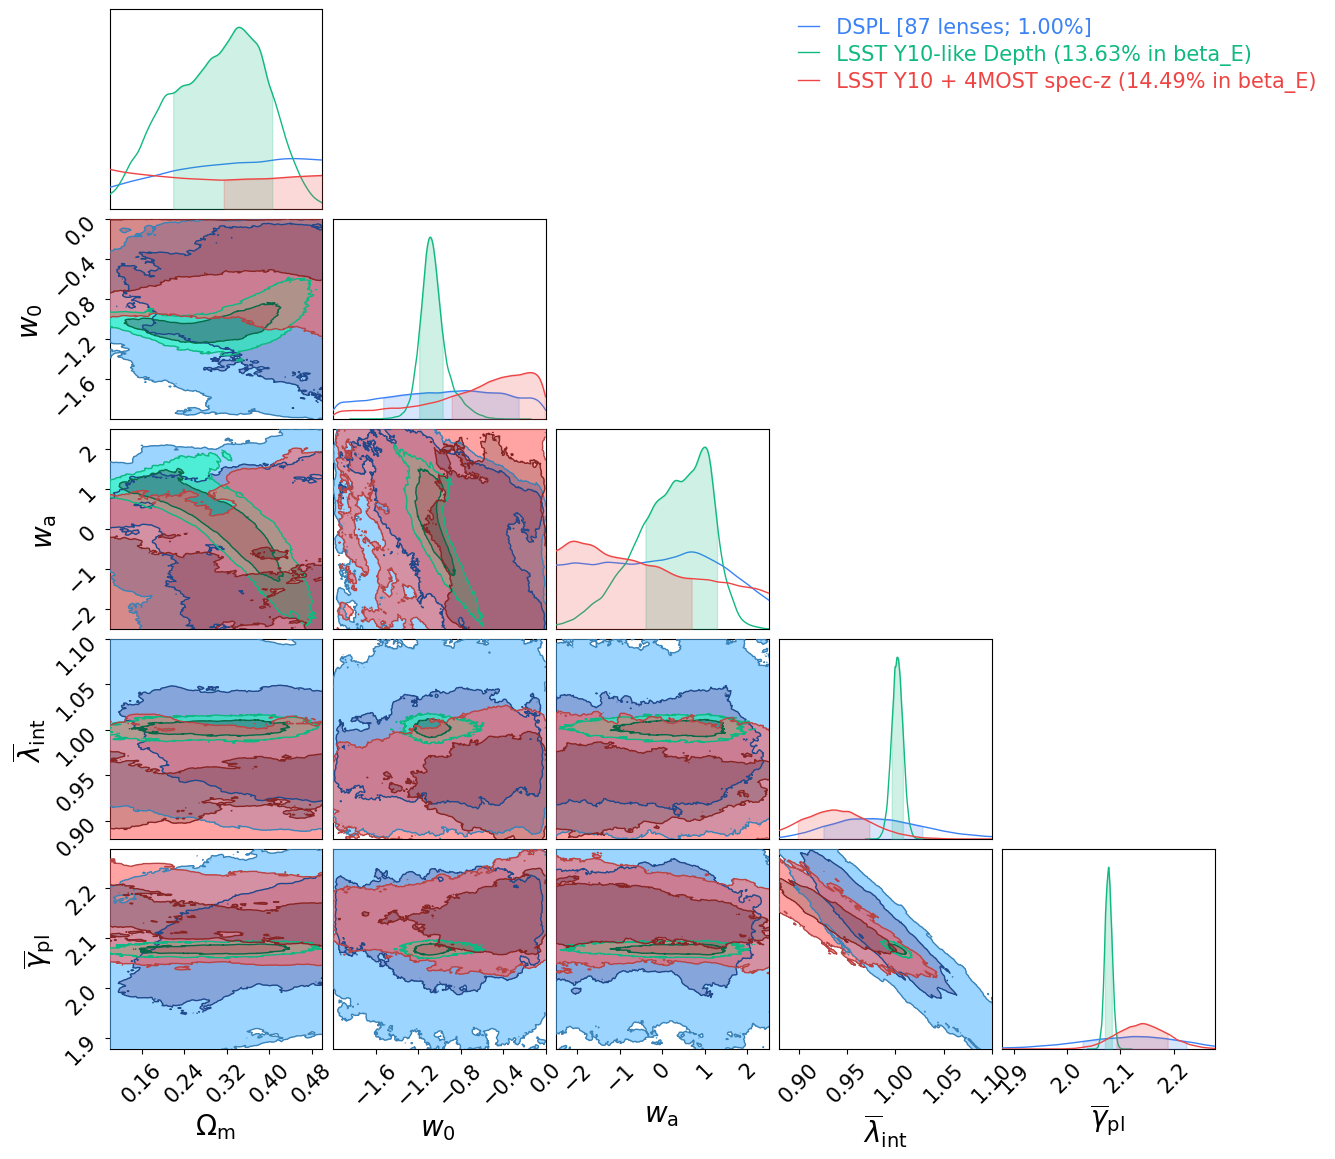

In [57]:

consumer = ChainConsumer()

consumer.add_chain(dspl_chain)

for key in keys_to_run_forecast:
    consumer.add_chain(pseudo_chains_dict[key], )


# consumer.add_chain(dspl_chain_prior)
# consumer.add_chain(pseudo_chain)
# consumer.add_chain(pseudo_chain_prior)
# consumer.add_chain(pseudo_chain_ds)
# consumer.add_chain(pseudo_chain_ds_prior)
# consumer.add_chain(joint_chain_prior)

extents = {
                r"$w_0$": [-2, -0],
                r"$w_{\rm a}$": [-2.5, 2.5],
                r"$\Omega_{\rm m}$": [0.1, 0.5],
                r"$\overline{\lambda}_{\rm int}$": [0.88, 1.1],
                r'$\overline{\gamma}_{\rm pl}$': [2.078-0.2, 2.078+0.2],
            }

plot_consumer(consumer, save_figures=True, figure_name='forecast_w0waCDM.pdf', extents=extents)

Parameter $w_{\rm a}$ in chain DSPL [87 lenses; 1.00%] is not constrained


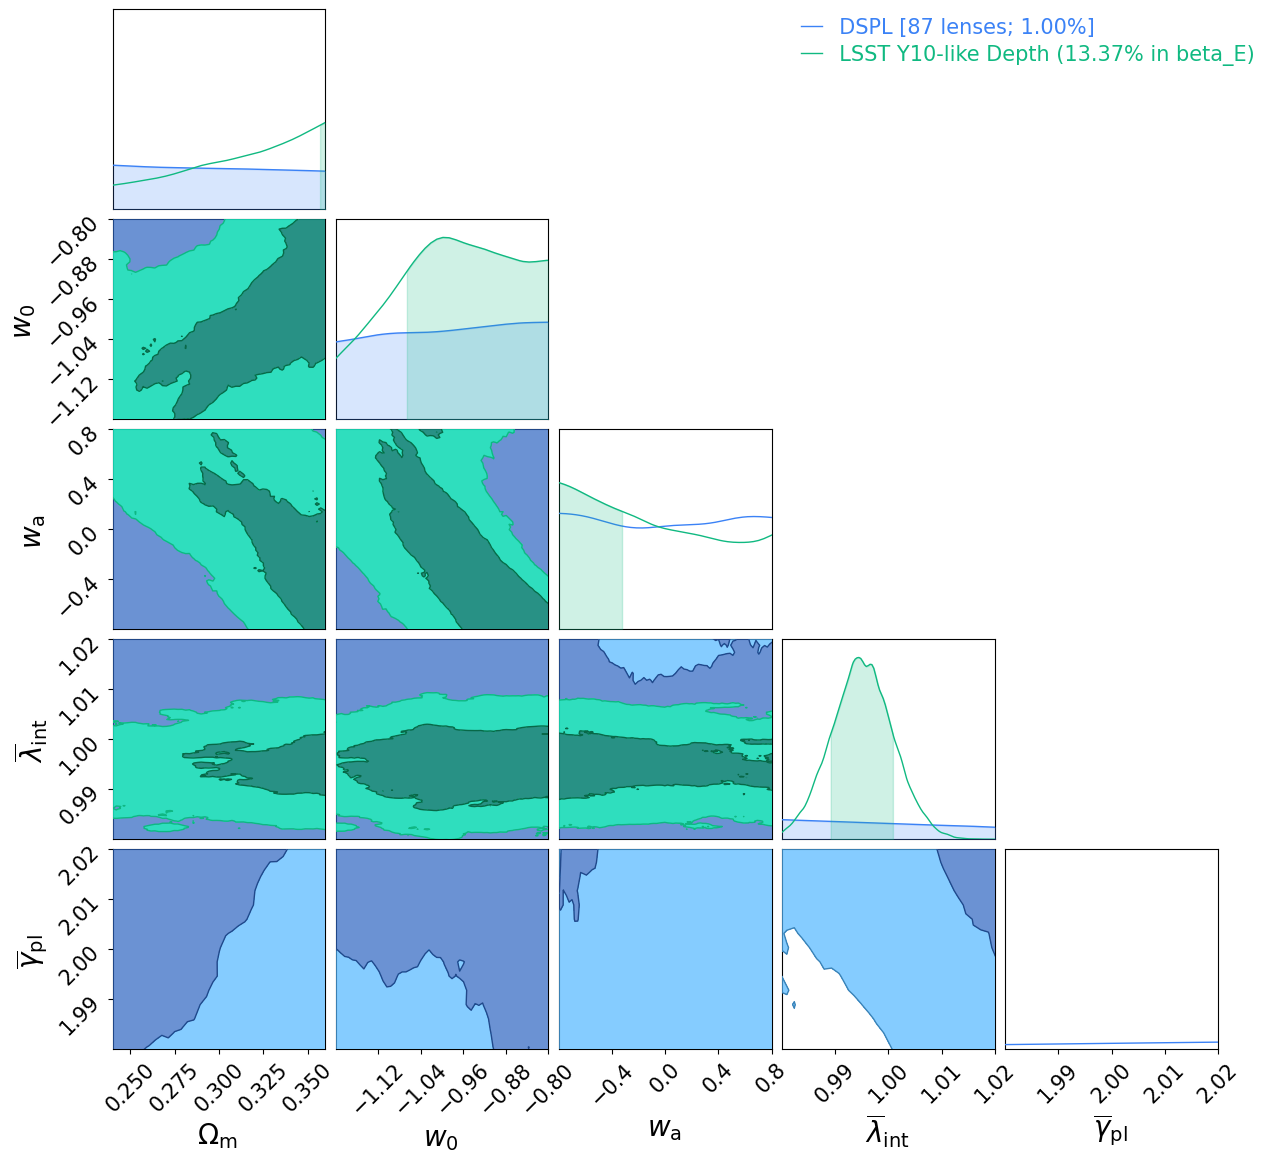

In [36]:

consumer = ChainConsumer()

consumer.add_chain(dspl_chain)

for key in keys_to_run_forecast:
    consumer.add_chain(pseudo_chains_dict[key])


# consumer.add_chain(dspl_chain_prior)
# consumer.add_chain(pseudo_chain)
# consumer.add_chain(pseudo_chain_prior)
# consumer.add_chain(pseudo_chain_ds)
# consumer.add_chain(pseudo_chain_ds_prior)
# consumer.add_chain(joint_chain_prior)

extents = {
                r"$w_0$": [-1.2, -0.8],
                r"$w_{\rm a}$": [-0.8, 0.8],
                r"$\Omega_{\rm m}$": [0.24, 0.36],
                r"$\overline{\lambda}_{\rm int}$": [0.98, 1.02],
                r'$\overline{\gamma}_{\rm pl}$': [1.98, 2.02],
            }

plot_consumer(consumer, save_figures=True, figure_name='forecast_w0waCDM_zoomed.pdf', extents=extents)

Parameter $\Omega_{\rm m}$ in chain DSPL [87 lenses; 1.00%] is not constrained
Parameter $w_{\rm a}$ in chain DSPL [87 lenses; 1.00%] is not constrained


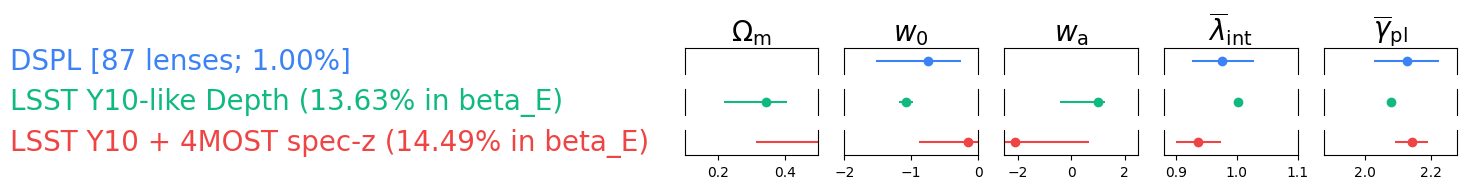

In [58]:
fig = consumer.plotter.plot_summary(errorbar=True);
fig.tight_layout()

In [22]:
latex_table = consumer.analysis.get_latex_table()
print(latex_table)

Parameter $w_{\rm a}$ in chain DSPL [87 lenses; 1.00%] is not constrained


\begin{table}
    \centering
    \caption{}
    \label{tab:model_params}
    \begin{tabular}{cccccc}
        \hline
		Model & $\Omega_{\rm m}$ & $w_0$ & $w_{\rm a}$ & $\overline{\lambda}_{\rm int}$ & $\overline{\gamma}_{\rm pl}$ \\ 
		\hline
		DSPL [87 lenses; 1.00%] & $0.47^{+0.24}_{-0.19}$ & $-0.96^{+0.31}_{-0.79}$ &  & $0.942^{+0.036}_{-0.025}$ & $2.070^{+0.067}_{-0.043}$ \\ 
		LSST Y10-like Depth (12.80% in beta_E) & $0.329^{+0.085}_{-0.127}$ & $-0.926^{+0.144}_{-0.065}$ & $0.04^{+0.84}_{-0.64}$ & $\left( 1005.0^{+3.7}_{-4.1} \right) \times 10^{-3}$ & $\left( 1999.6^{+5.1}_{-5.5} \right) \times 10^{-3}$ \\ 
		\hline
    \end{tabular}
\end{table}
